In [1]:
import tetrapolyscope as ps
import interactive_polyscope
from IPython.display import Image, display, HTML

%gui polyscope

[polyscope] Backend: openGL3_glfw -- Loaded openGL version: 4.1 Metal - 88.1


In [2]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import numpy.typing as npt

import pandas as pd

In [3]:
from TetriumColor.Observer import Observer, Cone, Neugebauer, InkGamut, CellNeugebauer, Pigment, Spectra, Illuminant, InkLibrary, load_neugebauer
import TetriumColor.Visualization as viz
from TetriumColor import ColorSpace, ColorSpaceType, PolyscopeDisplayType

objc[23906]: Class GLFWWindowDelegate is implemented in both /Users/jessicalee/anaconda3/envs/chromalab/lib/python3.11/site-packages/polyscope_bindings.cpython-311-darwin.so (0x10864e720) and /Users/jessicalee/anaconda3/envs/chromalab/lib/python3.11/site-packages/open3d/cpu/pybind.cpython-311-darwin.so (0x34b8c2db0). One of the two will be used. Which one is undefined.
objc[23906]: Class GLFWApplicationDelegate is implemented in both /Users/jessicalee/anaconda3/envs/chromalab/lib/python3.11/site-packages/polyscope_bindings.cpython-311-darwin.so (0x10864e6f8) and /Users/jessicalee/anaconda3/envs/chromalab/lib/python3.11/site-packages/open3d/cpu/pybind.cpython-311-darwin.so (0x34b8c2e28). One of the two will be used. Which one is undefined.
objc[23906]: Class GLFWContentView is implemented in both /Users/jessicalee/anaconda3/envs/chromalab/lib/python3.11/site-packages/polyscope_bindings.cpython-311-darwin.so (0x10864e770) and /Users/jessicalee/anaconda3/envs/chromalab/lib/python3.11/site

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
screenshot_count = 0
! mkdir -p screenshots
def save_ps_screenshot():
    global screenshot_count
    ps.show()  # renders window
    fname = f"screenshots/screenshot_{screenshot_count}.png"
    ps.screenshot(fname)
    # Display in notebook
    display(Image(filename=fname, width=400)) # need to use this for pdf export
    # display(HTML(f'<img src="screenshot_{screenshot_count}.png" style="width:50%;">'))

    screenshot_count += 1

In [6]:
def save_top_inks_as_csv(top_volumes, filename):
    import csv

    # Save top_volumes_all_fp_inks to a CSV file
    with open(filename, "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["Volume", "Ink Combination"])  # Header
        for volume, inks in top_volumes:
            writer.writerow([volume, ", ".join(inks)])  # Write volume and ink combination

def load_top_inks(filename):
    top_volumes = []
    with open(filename, "r") as csvfile:
        reader = csv.reader(csvfile)
        next(reader)  # Skip header
        for row in reader:
            volume = float(row[0])
            inks = row[1].split(", ")
            top_volumes.append((volume, inks))
    return top_volumes

In [7]:
from colorsys import rgb_to_hsv
import math

def plot_inks_by_hue(ink_dataset, wavelengths):
    """
    Plots the inks in the dataset sorted by hue.

    Parameters:
    - ink_dataset: dict, a dictionary of ink names and their corresponding Spectra objects.
    - wavelengths: numpy.ndarray, array of wavelengths corresponding to the spectra data.
    """
    # Convert RGB to HSV and sort by hue
    def get_hue(spectra):
        r, g, b = spectra.to_rgb()
        h, _, _ = rgb_to_hsv(r, g, b)
        return h

    # Sort inks by hue
    sorted_inks = sorted(ink_dataset.items(), key=lambda item: get_hue(item[1]))

    # Plot sorted inks row by row by hue
    num_inks = len(sorted_inks)
    cols = math.ceil(math.sqrt(num_inks))
    rows = math.ceil(num_inks / cols)

    plt.figure(figsize=(15, 15))

    for idx, (name, spectra) in enumerate(sorted_inks):
        plt.subplot(rows, cols, idx + 1)
        plt.plot(wavelengths, spectra.data, c=spectra.to_rgb())
        plt.title(name[:10], fontsize=8)  # Show only the first 10 characters of the name
        plt.xlabel("Wavelength (nm)", fontsize=6)
        plt.ylabel("Reflectance", fontsize=6)
        plt.grid(True)
        plt.xlim(wavelengths[0], wavelengths[-1])
        plt.ylim(0, 1.4)
        plt.tick_params(axis='both', which='major', labelsize=6)

    plt.tight_layout()
    plt.show()


def show_top_k_combinations(top_volumes, inkset,  k=10):
    """
    Displays the top k ink combinations with their volumes.
    
    Parameters:
    - top_volumes: list of tuples (volume, [ink names])
    - k: number of top combinations to display
    """
    # Plot the spectra of the top inks for the first k entries
    plt.figure(figsize=(10, 10))

    for idx, (volume, ink_names) in enumerate(top_volumes[:k]):
        plt.subplot(math.ceil(k / 4), 4, idx + 1)  # Create a subplot for each entry
        for ink_name in ink_names:  # Plot the spectra of the first 4 inks
            spectra = inkset[ink_name]
            plt.plot(wavelengths, spectra.data, label=ink_name[:10], c=spectra.to_rgb())  # Show only the first 10 characters of the name
        plt.title(f"Volume: {volume:.2e}", fontsize=10)
        plt.xlabel("Wavelength (nm)", fontsize=8)
        plt.ylabel("Reflectance", fontsize=8)
        plt.grid(True)
        plt.xlim(wavelengths[0], wavelengths[-1])
        plt.ylim(0, 1)
        plt.legend(fontsize=6)
        plt.tick_params(axis='both', which='major', labelsize=6)

    plt.tight_layout()
    plt.show()


### Load Screen Printing Inkset

In [76]:
 ### Analyze our 100 ink gamut ###
    # Load the CSV data
data_path = "../../data/screenprinting/screenprinting-2.csv"
df = pd.read_csv(data_path)

spectras = df.iloc[1:, 2:].to_numpy()  # Extract reflectance data
wavelengths = np.arange(400, 701, 10)  # Wavelengths from 400 to 700 nm in steps of 10 nm
# Create Spectra objects for each ink
all_inks = {}
for i in range(spectras.shape[0]):
    name = "".join([str(df.iloc[i + 1, j]) for j in [1]])
    if 'fluorescent' in name.lower():
        if name.lower() != 'blue fluorescent':
            continue
    all_inks[name] = Spectra(data=spectras[i], wavelengths=wavelengths, normalized=False)

fp_paper = all_inks["paper"]
del all_inks["paper"]  # Remove paper from the inks

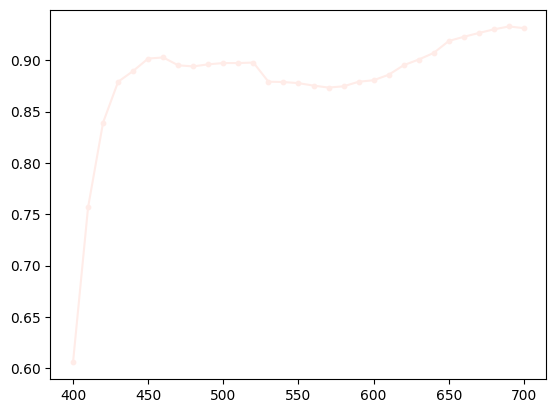

In [77]:
fp_paper.plot()

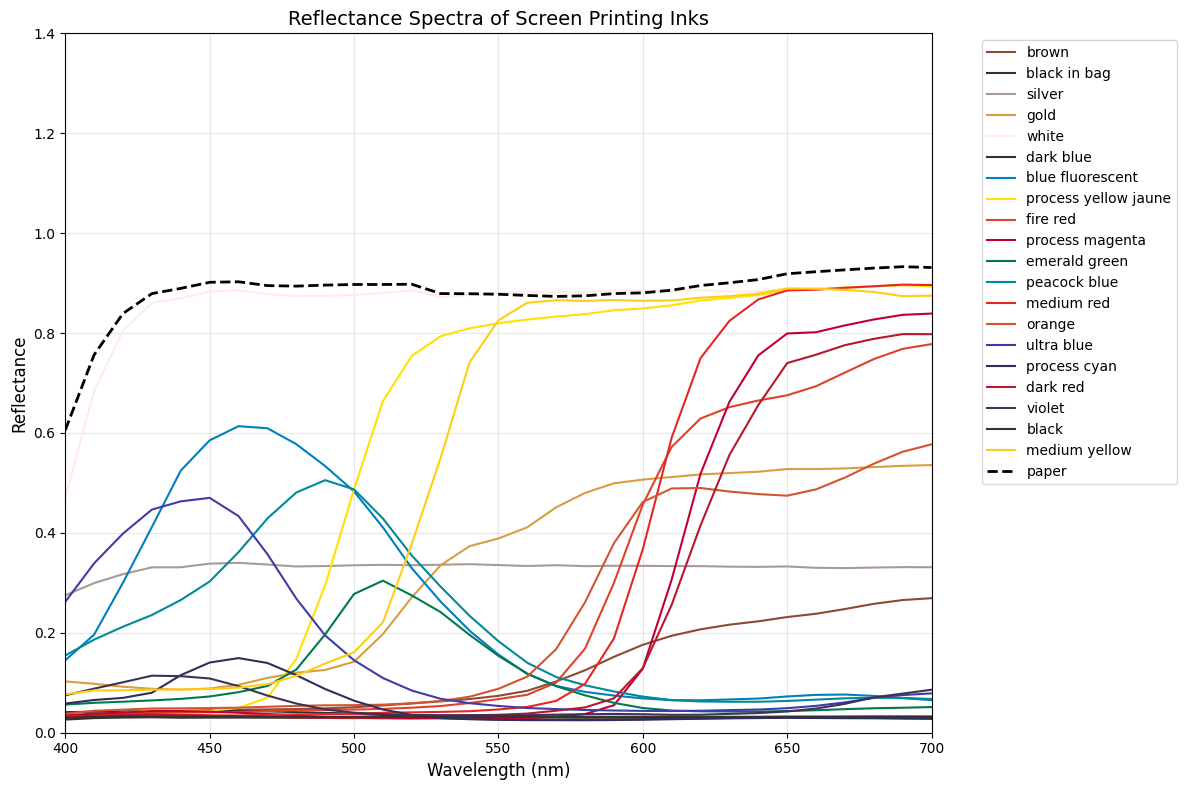

In [78]:
plt.figure(figsize=(12, 8))

# Plot each ink's spectrum
for ink_name, ink_spectra in all_inks.items():
    plt.plot(wavelengths, ink_spectra.data, label=ink_name, linewidth=1.5, c=ink_spectra.to_rgb())

# Add the paper spectrum as a black dashed line
plt.plot(wavelengths, fp_paper.data, label='paper', color='black', linestyle='--', linewidth=2)

# Add labels and legend
plt.xlabel('Wavelength (nm)', fontsize=12)
plt.ylabel('Reflectance', fontsize=12)
plt.title('Reflectance Spectra of Screen Printing Inks', fontsize=14)
plt.xlim(wavelengths[0], wavelengths[-1])
plt.ylim(0, 1.4)
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

plt.tight_layout()
plt.show()

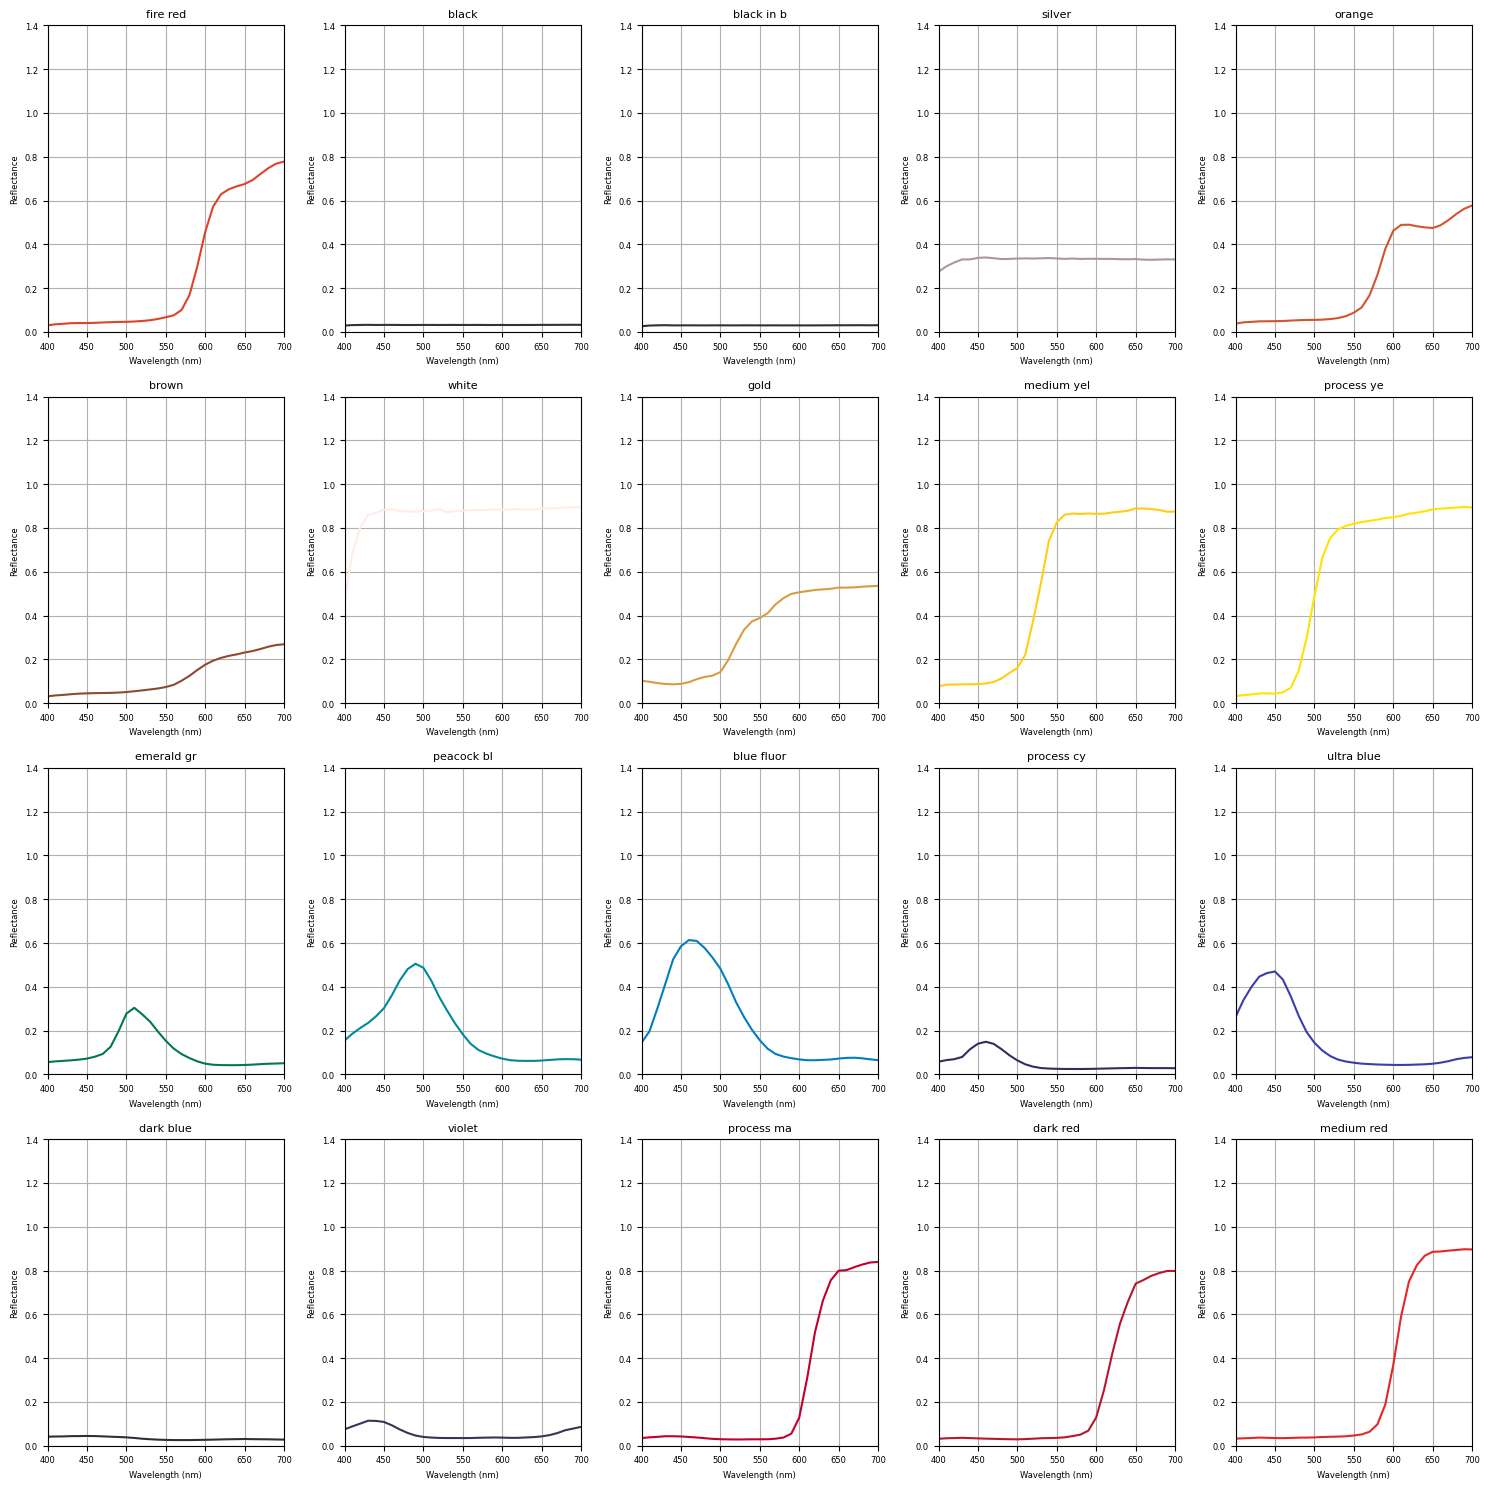

In [79]:
plot_inks_by_hue(all_inks, wavelengths)

## Observer analysis (tetrachromat)

In [80]:
# Define observer and illuminant
d65 = Illuminant.get("d65")
tetrachromat = Observer.tetrachromat(illuminant=d65, wavelengths=wavelengths)

In [81]:
 # Initialize the ink library|
ink_library = InkLibrary(all_inks, fp_paper)

In [82]:
# Perform convex hull search
# top_width_all_inks = ink_library.distance_search(tetrachromat, d65)
# save_top_inks_as_csv(top_width_all_inks, "top_widths_all_screen_printing_inks.csv")


## -- currently not working but hacked a solution together either way using visual cues
# top_width_all_inks = load_top_inks("top_widths_all_screen_printing_inks.csv")


In [83]:
# Perform convex hull search
top_volumes_all_inks = ink_library.convex_hull_search(tetrachromat, d65, k=4)
save_top_inks_as_csv(top_volumes_all_inks, "./ink-combos/top_volumes_all_screen_printing_inks.csv")


top_volumes_all_inks = ink_library.convex_hull_search(tetrachromat, d65, k=5)
save_top_inks_as_csv(top_volumes_all_inks, "./ink-combos/top_volumes_k5_all_screen_printing_inks.csv")

loading km cache: 100%|██████████| 6175/6175.0 [00:00<00:00, 123137.25it/s]
finding best inkset: 100%|██████████| 4845/4845.0 [00:00<00:00, 19532.17it/s]
loading km cache: 100%|██████████| 21679/21679.0 [00:00<00:00, 118304.74it/s]
finding best inkset: 100%|██████████| 15504/15504.0 [00:01<00:00, 13399.93it/s]


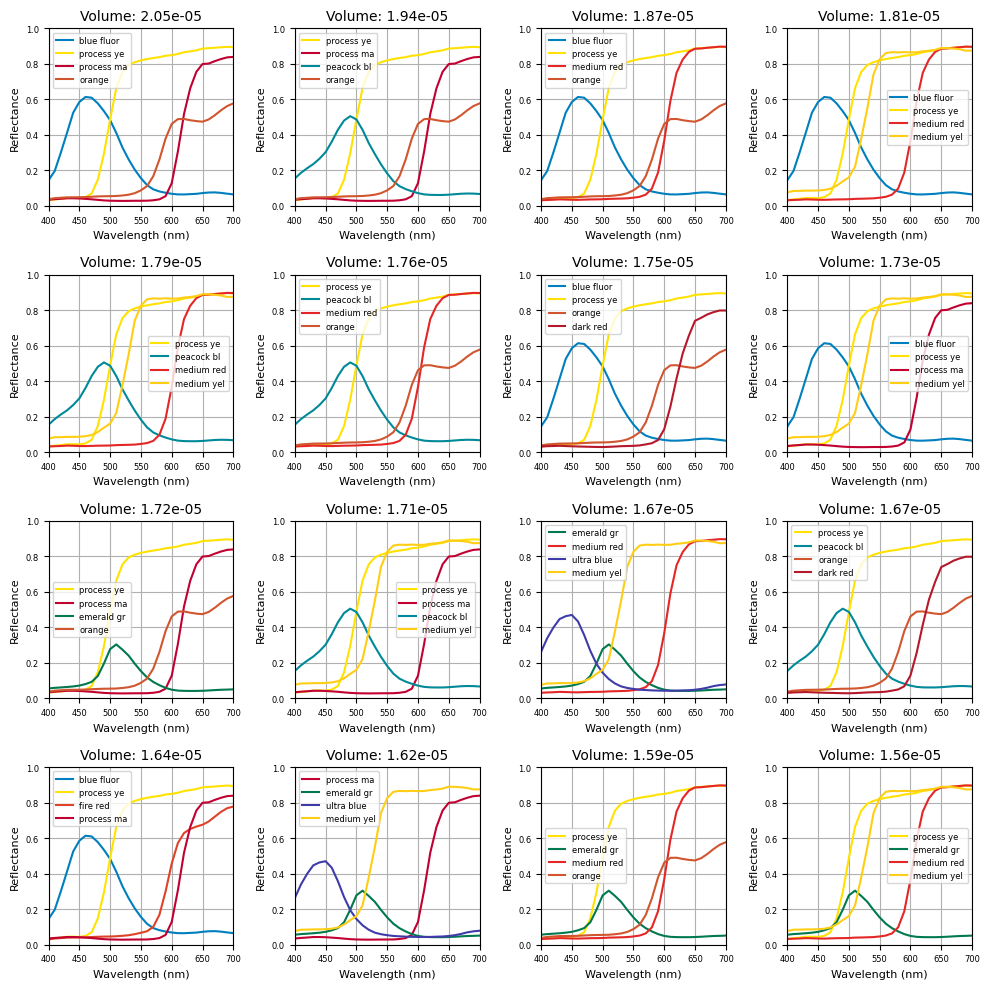

In [ ]:
top_volumes_all_inks = load_top_inks("./ink-combos/top_volumes_all_screen_printing_inks.csv")
show_top_k_combinations(top_volumes_all_inks, all_inks, k=16)

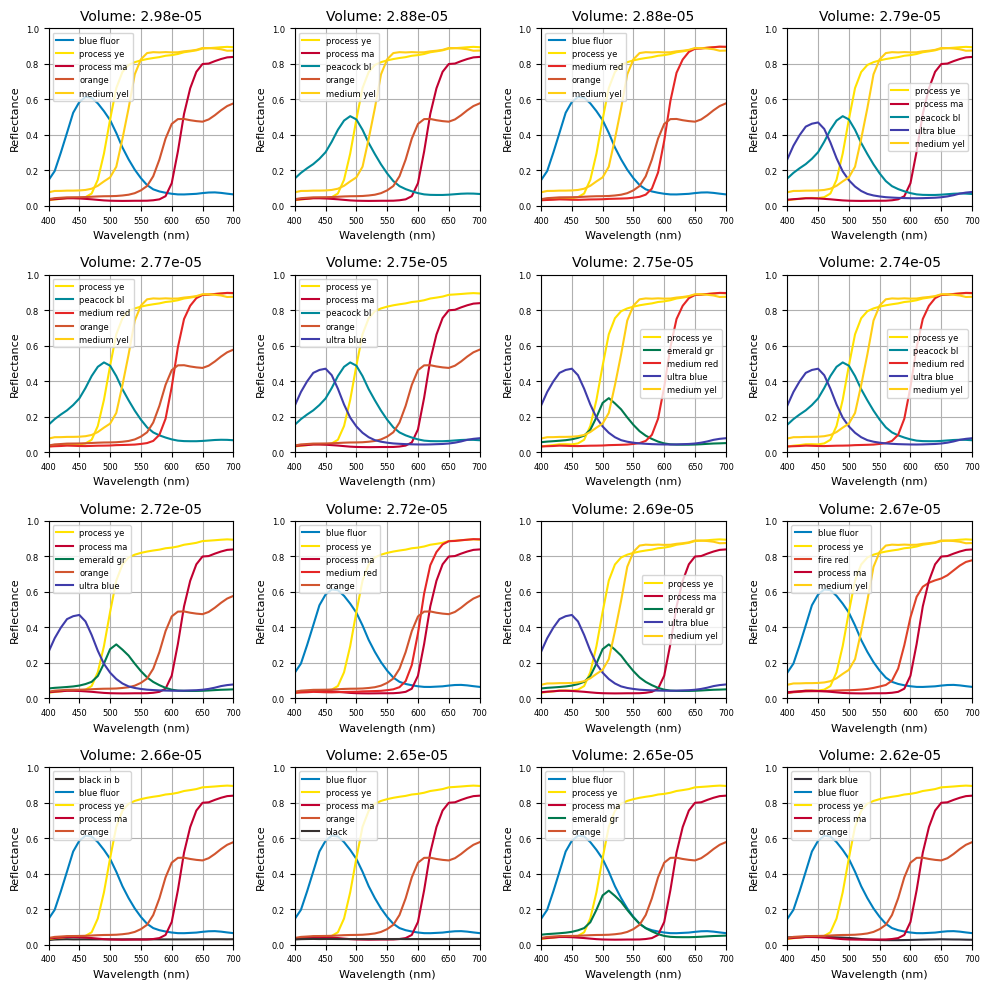

In [ ]:
top_volumes_all_inks = load_top_inks("./ink-combos/top_volumes_k5_all_screen_printing_inks.csv")
show_top_k_combinations(top_volumes_all_inks, all_inks, k=16)

In [91]:
chosen_idx = 0
best4 = [all_inks[ink_name] for ink_name in top_volumes_all_inks[chosen_idx][1]]
# best4_width = [all_inks[ink_name] for ink_name in top_width_all_inks[0][1]] 

['blue fluorescent', 'process yellow jaune', 'process magenta', 'orange']

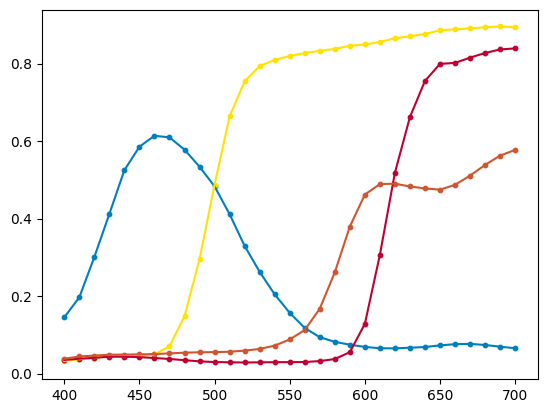

In [92]:
[all_inks[ink_name].plot() for ink_name in top_volumes_all_inks[chosen_idx][1]]
[ink_name for ink_name in top_volumes_all_inks[chosen_idx][1]]


In [93]:
gamut = InkGamut(best4, fp_paper, d65)
fp_point_cloud, fp_percentages = gamut.get_point_cloud(tetrachromat)

Generating point cloud: 0it [00:00, ?it/s]

Generating point cloud: 1it [00:00, 46.16it/s]


In [94]:
buckets = gamut.get_buckets(tetrachromat)

Generating point cloud: 1it [00:00, 13.53it/s]

Point cloud generated.


In [95]:
def get_spectras_from_metamer(metamer_idx):
    np.set_printoptions(precision=4, suppress=True)
    metamer1 = gamut.get_spectra(buckets[metamer_idx][1][0])
    metamer2 = gamut.get_spectra(buckets[metamer_idx][1][1])
    cones = tetrachromat.observe_spectras([metamer1, metamer2])
    print("cone percentages", np.array([cone.data for cone in cones]))
    print("difference", np.abs(cones[0] - cones[1]))
    # Format and print the ink percentages for this metamer
    print("ink percentages", np.array(buckets[metamer_idx][1]))

    metamer1.plot(); metamer2.plot()
    return [metamer1, metamer2]

In [96]:
def visualize_metamer_grid(gamut, buckets, img_size=50):
    # Create a 50x50 grid image
    grid = np.zeros((img_size, img_size, 3))
    
    # Calculate the total number of available metamers
    num_metamers = min(img_size * img_size, len(buckets))
    
    # Fill the grid with RGB values from different metamer pairs
    for i in range(img_size):
        for j in range(img_size):
            idx = i * img_size + j
            if idx < num_metamers:
                # Get the first spectrum from each metamer pair
                spectrum = gamut.get_spectra(buckets[idx][1][0])
                rgb = spectrum.to_rgb()
                
                # Clip values to be between 0 and 1
                grid[i, j] = np.clip(rgb, 0, 1)
    
    # Display the grid
    plt.figure(figsize=(10, 10))
    plt.imshow(grid)
    plt.title(f"Grid of Metamers (First {num_metamers} pairs)")
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    return grid

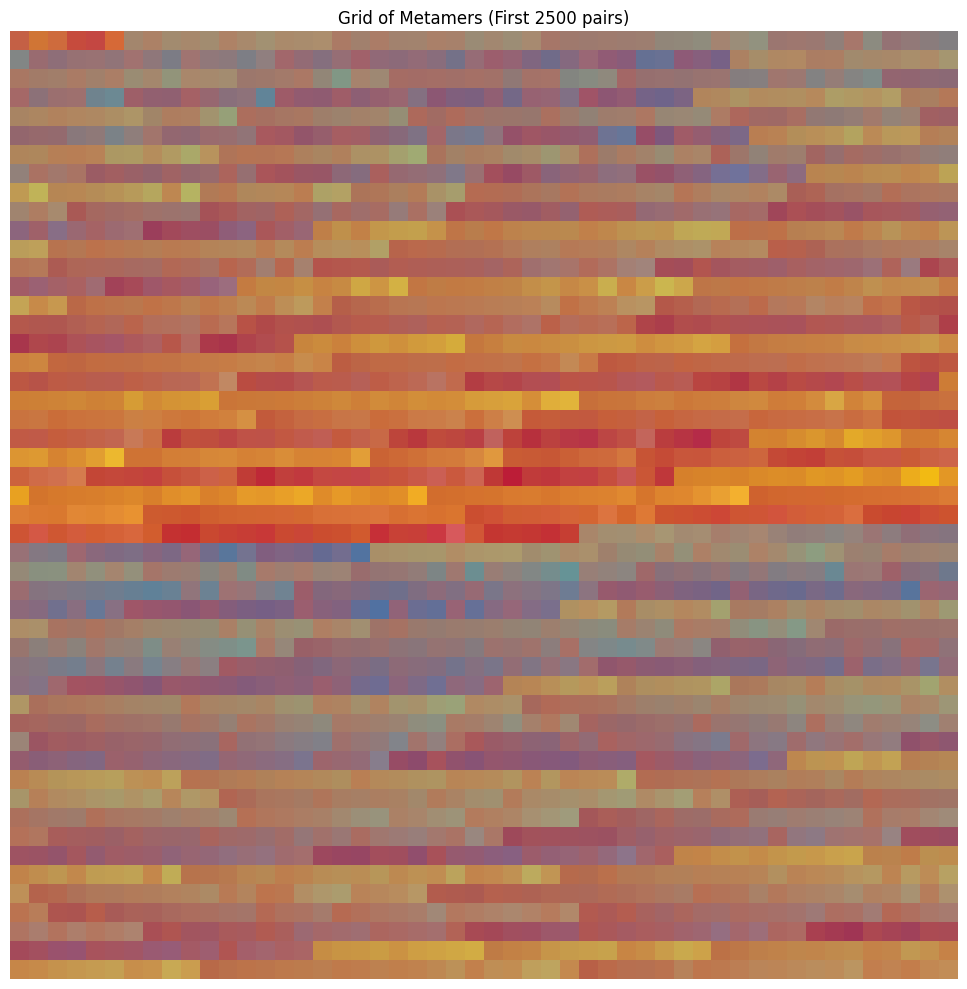

array([[[ 0.7687,  0.3795,  0.2726],
        [ 0.8168,  0.4614,  0.2099],
        [ 0.8096,  0.4199,  0.2429],
        ..., 
        [ 0.5738,  0.4777,  0.4708],
        [ 0.5442,  0.488 ,  0.4887],
        [ 0.5136,  0.4989,  0.507 ]],

       [[ 0.5125,  0.5275,  0.5216],
        [ 0.6031,  0.4208,  0.441 ],
        [ 0.5576,  0.4335,  0.4731],
        ..., 
        [ 0.6634,  0.5574,  0.4222],
        [ 0.6806,  0.5475,  0.4116],
        [ 0.6499,  0.5898,  0.4423]],

       [[ 0.6655,  0.4687,  0.3906],
        [ 0.6382,  0.4843,  0.4112],
        [ 0.6315,  0.4974,  0.4195],
        ..., 
        [ 0.5695,  0.3979,  0.4458],
        [ 0.5586,  0.413 ,  0.4557],
        [ 0.548 ,  0.4156,  0.4627]],

       ..., 
       [[ 0.6901,  0.4554,  0.3847],
        [ 0.6683,  0.4932,  0.4322],
        [ 0.7012,  0.4523,  0.3703],
        ..., 
        [ 0.6301,  0.2567,  0.3538],
        [ 0.6735,  0.2966,  0.3275],
        [ 0.6641,  0.2947,  0.3368]],

       [[ 0.6464,  0.2917,  0.3554]

In [97]:
visualize_metamer_grid(gamut, buckets, img_size=50)

In [ ]:
get_spectras_from_metamer(5)

ValueError: matmul: Input operand 1 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)

: 

In [39]:
cs = ColorSpace(tetrachromat)

In [40]:
all_inks_as_points = tetrachromat.observe_spectras(all_inks.values())
all_inks_point_cloud = cs.convert(all_inks_as_points, ColorSpaceType.CONE, ColorSpaceType.HERING)[:, 1:]
all_inks_srgbs = cs.convert(all_inks_as_points, ColorSpaceType.CONE, ColorSpaceType.SRGB)

In [41]:
ps.init()
ps.set_always_redraw(False)
ps.set_ground_plane_mode('shadow_only')
ps.set_SSAA_factor(2)
ps.set_window_size(720, 720)
factor = 0.1575  # 0.1/5.25
viz.ps.set_background_color((factor, factor, factor, 1))

viz.RenderOBS("observer", cs, PolyscopeDisplayType.HERING_MAXBASIS, num_samples=1000)
viz.ps.get_surface_mesh("observer").set_transparency(0.3)
viz.RenderPointCloud("fp_points", cs.convert(fp_point_cloud, ColorSpaceType.CONE, ColorSpaceType.HERING)[:, 1:])
viz.RenderPointCloud("all_fps", all_inks_point_cloud, all_inks_srgbs)

viz.RenderMetamericDirection("meta_dir", tetrachromat, PolyscopeDisplayType.HERING_MAXBASIS, 2, np.array([0, 0, 0]), radius=0.005, scale=1.2)
viz.ps.show()

Loaded full colors from cache: full_colors_dd642fe82a2a85365fec867dffd5caac_1000.pkl


RAYCAST_SPHERE
SPHERE_PROPAGATE_COLOR
SHADE_COLOR
LIGHT_MATCAP


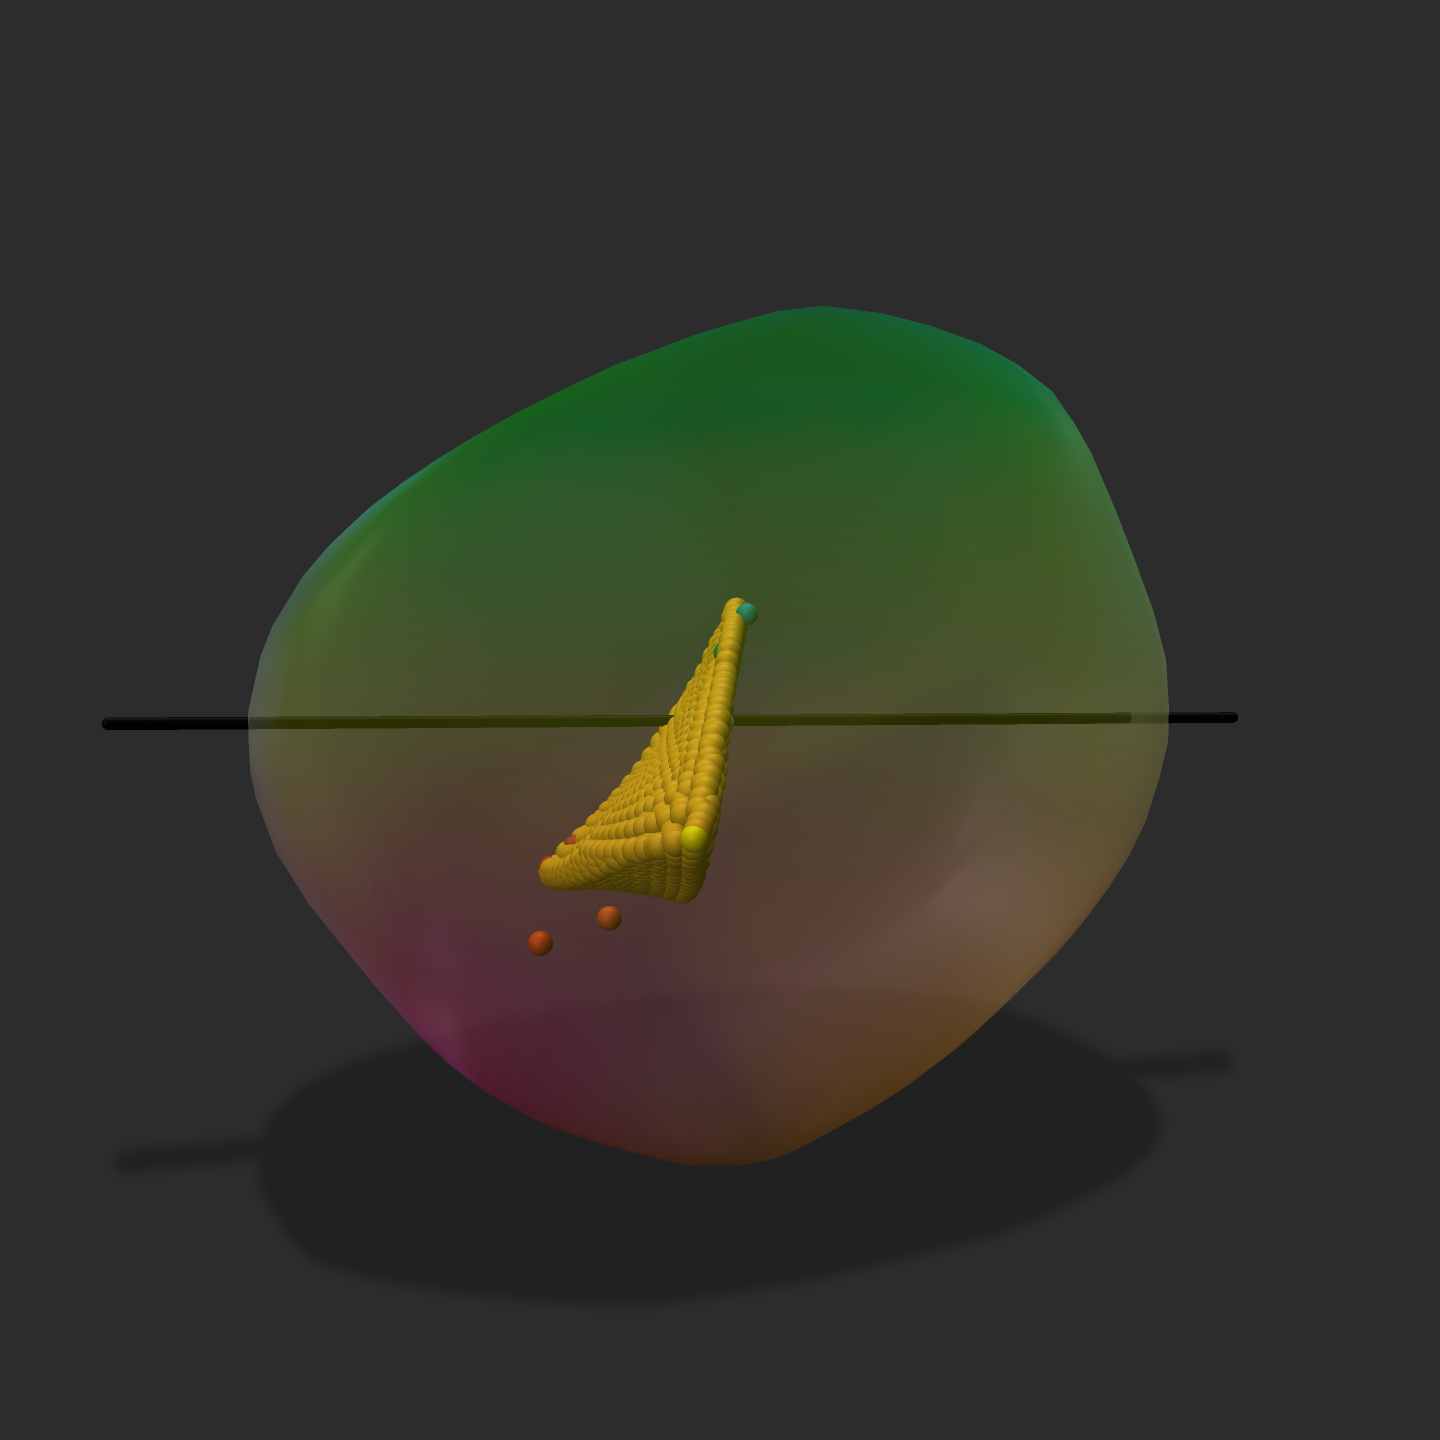

In [43]:
save_ps_screenshot()

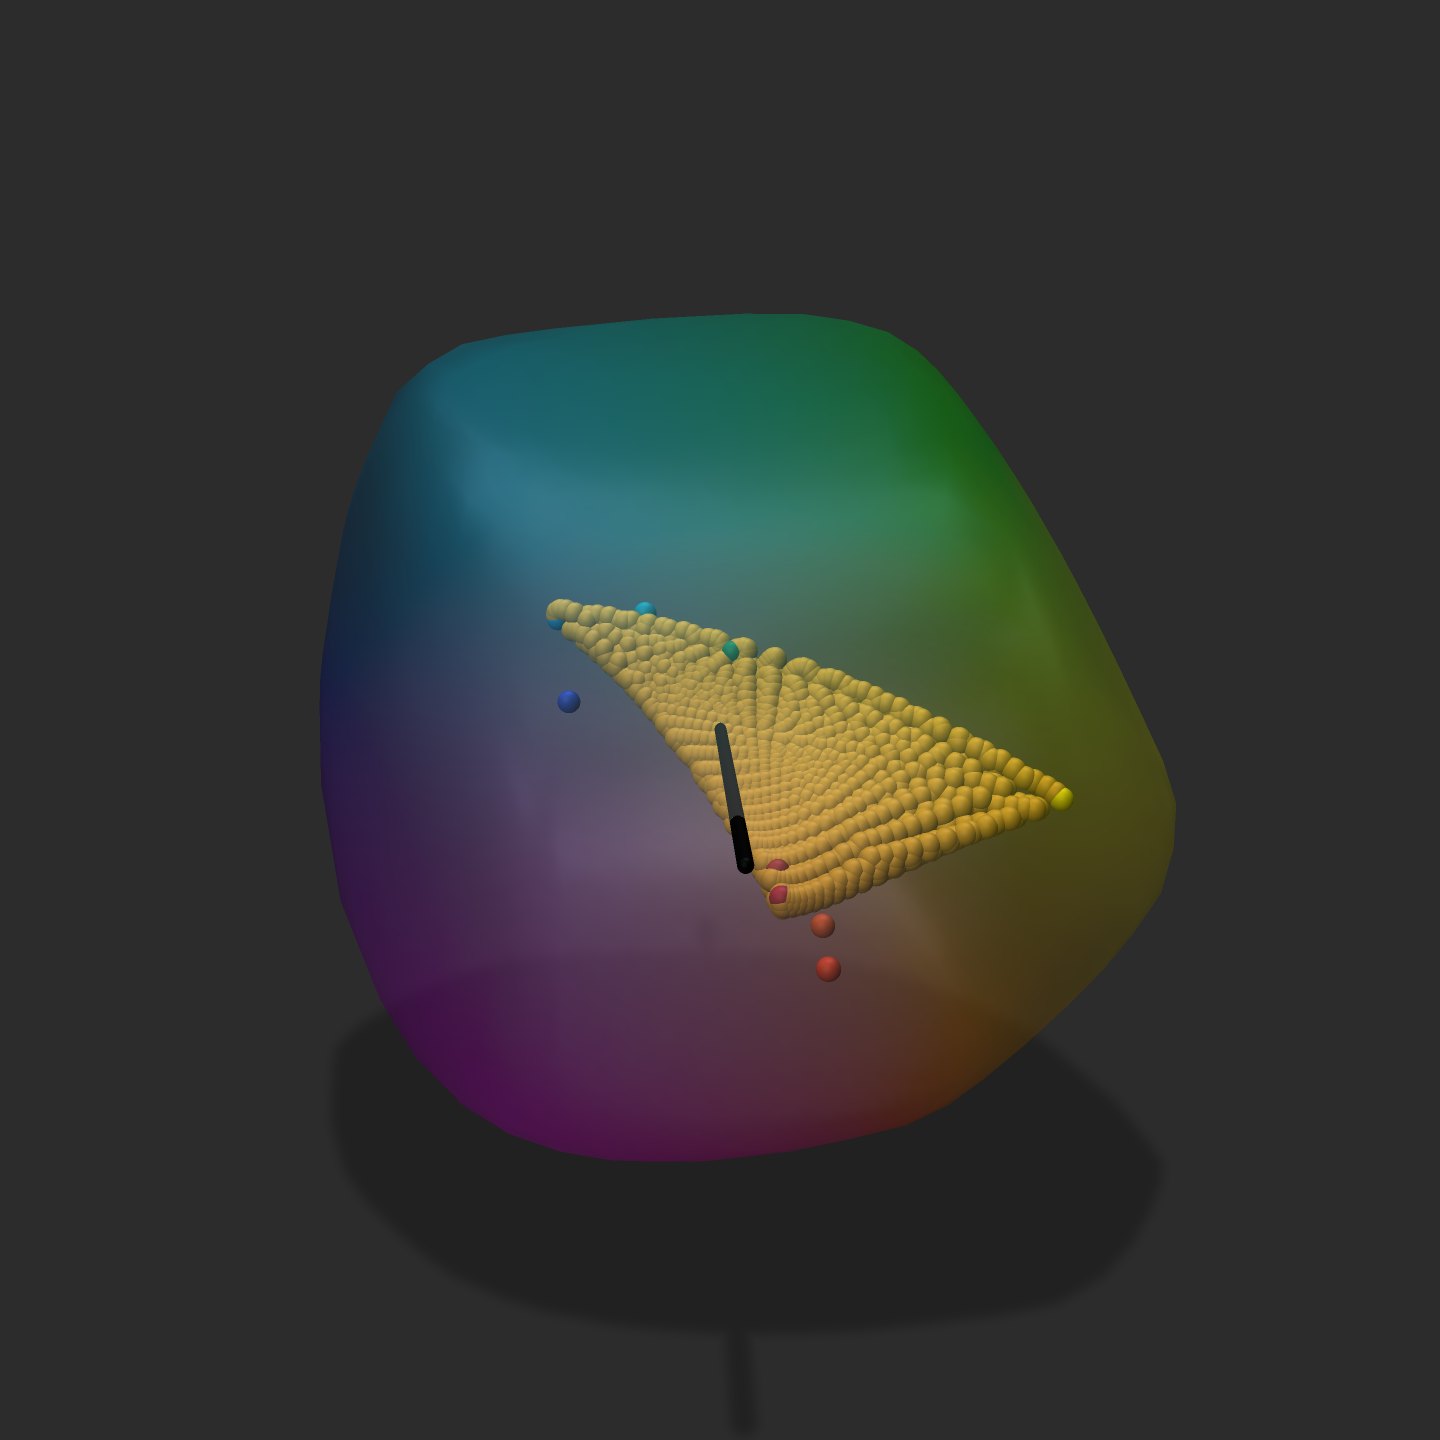

In [49]:
save_ps_screenshot()